# Iterative Archetypal Analysis Functionalities Demonstration

**author:** Jonathan Yik Chang Ting

**email:** Jonathan.Ting@anu.edu.au

This is a notebook to demonstrate the functionalities provided by *archetypes.py* for the archetypal analysis of given datasets in an iterative manner. The code is developed based on the [code structure and functionalities for visualisation of the *archetypes.py* written by Benyamin Motevalli](https://researchdata.edu.au/archetypal-analysis-package/1424520), who in turn developed his code based on ["Archetypal Analysis" by Adele Cutler and Leo Breiman, Technometrics, November 1994, Vol.36, No.4, pp. 338-347](https://www.jstor.org/stable/1269949).

## Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import chdir, getcwd
import pickle
import requests

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.distance import cdist
import seaborn as sns
import sklearn
from sklearn.datasets import load_diabetes, make_blobs
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# chdir('/scratch/q27/jt5911/iterative-archetypal-analysis/iteraa/docs')
import iteraa
from iteraa import ArchetypalAnalysis, createSimplexAx, mapAlfaToSimplex, plotRadarDatapoints, plotTSNE


# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  iteraa: {iteraa.__version__}")
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  scipy: {scipy.__version__}")
print(f"  seaborn: {sns.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")

Versions of imported libraries:
  iteraa: 0.1.0
  matplotlib: 3.9.1
  numpy: 1.26.4
  pandas: 2.2.2
  scipy: 1.12.0
  seaborn: 0.13.2
  scikit-learn: 1.5.1


In [3]:
# Figure settings
# Variables specific for figures plotting
FIG_SIZE, DPI = (7, 4), None
CONT_PALETTE, QUAL_PALETTE = 'viridis', 'tab10'
sns.set_style('ticks')
# sns.set_palette(CONT_PALETTE)

SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE, TITLE_SIZE = 8, 10, 12, 14
plt.rc('font', size=LARGE_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('legend', title_fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

In [4]:
# General variables
RANDOM_STATE = 42
NUM_DIM_MANIFOLD = 2
VERBOSE = True
NUM_JOBS = 48

# Variables specific for splitting data into subsets
SHUFFLE = True  # Whether to shuffle data samples before splitting.

# Variables specific for archetypes.py functionalities
C = 0.0001  # constraint coefficient to ensure that the summation of alpha and beta equals to 1.

# Variables specific for the archetypal analysis algorithm provided by the SPArse Modeling Software (SPAMS) package
ROBUST = False  # Whether to use modified AA algorithm to deal with outliers
TOLERANCE = 0.001  # Threshold to decide when to stop optimisation.
COMPUTE_XTX = False  # Whether to compute X^T * X
STEPS_FISTA = 3  # Number of steps for fast iterative shrinkage-thresholding algorithm
STEPS_AS = 50  # Number of steps for active set algorithm
RANDOM_INIT = False  # Whether to initialise the archetypes randomly

# Set directory path
FIGS_DIR_PATH = 'figs/'

# Set random seed
np.random.seed(RANDOM_STATE)

### Data Visualisation

For the visualisation of the (often high-dimensional) data, *t*-distributed stochastic neighbour embedding (*t*-SNE) is used.

#### Advantages
*t*-SNE converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student's *t*-distributions. This allows *t*-SNE to be particularly sensitive to local structure and has a few other advantages over existing techniques:
- Revealing the structure at many scales on a single map.
- Revealing data that lie in multiple, different, manifolds or clusters.
- Reducing the tendency to crowd points together at the center.

#### Disadvantages
The disadvantages to using *t*-SNE are:
- *t*-SNE is computationally expensive, and can take several hours on million-sample datasets where PCA will finish in seconds or minutes.
- The Barnes-Hut t-SNE method is limited to two or three dimensional embeddings.
- The algorithm is stochastic and multiple restarts with different seeds can yield different embeddings. However, it is perfectly legitimate to pick the embedding with the least error.

#### Recommendations
*t*-SNE converts similarities between data points to joint probabilities and minimises the Kullback-Leibler (KL) divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. The KL divergence of the joint probabilities in the original space and the embedded space are minimised by gradient descent. Note that the KL divergence is not convex, i.e. multiple restarts with different initialisations will end up in local minima of the KL divergence. Hence, it is useful to try different seeds and select the embedding with the lowest KL divergence.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples. 

#### Why not UMAP?
Compared to uniform manifold approximation and projection (UMAP), *t*-SNE provides higher flexibility for the emphasis of local structures. While UMAP was thought to be superior in preserving global data structure, this was recently found to be attributed to the initialisation method (Users are directed to the [publication of Kobak and Linderman in 2021](https://doi.org/10.1038/nbt.4314) for further details). Consequently, *t*-SNE with informative initialisation (such as PCA initialisation) performs as well as UMAP in terms of preservation of global structure.

#### Why not other techniques?

While Isomap, LLE and variants are best suited to unfold a single continuous low dimensional manifold, *t*-SNE will focus on the local structure of the data and will tend to extract clustered local groups of samples as highlighted on the S-curve example. This ability to group samples based on the local structure might be beneficial to visually disentangle a dataset that comprises several manifolds at once as is the case in the digits dataset.

#### Essential *t*-SNE Parameters

Parameters controlling the optimisation of *t*-SNE and therefore possibly the quality of the resulting embedding:
- **perplexity**: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value from [5, 50]. Different values can result in significantly different results. The perplexity must be less than the number of samples.
- **early_exaggeration**: Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high.
- **learning_rate**: The learning rate for *t*-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help. The 'auto' option sets the learning_rate to $\text{max}(N / \text{early\_exaggeration} / 4, 50)$ where $N$ is the sample size, following the [work of Belkina et al.](https://doi.org/10.1038/s41467-019-13055-y) and the [work of Kobak and Berens](https://doi.org/10.1038/s41467-019-13056-x).
- **n_iter**: Maximum number of iterations for the optimization. Should be at least 250.
- **angle**: Angular size (referred to as theta in the [work of van der Maaten](https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf)) of a distant node as measured from a point. If this size is below 'angle' then it is used as a summary node of all points contained within it. This method is not very sensitive to changes in this parameter in the range of [0.2, 0.8]. Angle less than 0.2 has quickly increasing computation time and angle greater 0.8 has quickly increasing error. Only used if **method**='barnes_hut' This is the trade-off between speed and accuracy for Barnes-Hut *t*-SNE. 

Other Parameters:
- **n_components**: Dimension of the embedded space.
- **min_grad_norm**: If the gradient norm is below this threshold, the optimization will be stopped.
- **metric**: The metric to use when calculating distance between instances in a feature array. The default is “euclidean” which is interpreted as squared euclidean distance.
- **init**: Initialisation of embedding. PCA initialisation cannot be used with precomputed distances and is usually more globally stable than random initialisation.
- **method**: By default the gradient calculation algorithm uses Barnes-Hut approximation running in $O(N\text{log}N)$ time. The 'exact' option will run on the slower, but exact, algorithm in $O(N^2)$ time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples.

The effects of changing the parameters of *t*-SNE can be understood from [some experiments visualised](https://distill.pub/2016/misread-tsne/)!

## Reference vs Iterative Archetypal Analysis

We will first use a few two-dimensional datasets to allow visual comparisons between the reference and iterative approaches to archetypal analysis of a given dataset.

### Arguments Description
- **nArchetypes**: Defines how many archetypes will be extracted. A positive integer. Setting to 1 return the mean of the data set. *Default = 2*.
- **iterative**: Whether to use the iterative or reference approach. *Default = False*.
- **nSubsets**: The number of subsets to split the data into if **iterative** = True. *Default = 10*.
- **shuffle**: Whether to shuffle the data samples before splitting. *Default = True*.
- **onlyZ**: Whether to stop running when archetypes are computed. Setting to True allows only archetypes and run time to be returned. *Default = False*.
- **C**: the weight on the constraint equation. Inversely proportional to the strength of constraint. *Default = 0.0001*. Constraint Equation: $$\sum\alpha = 1,$$ $$\sum\beta = 1$$

The following arguments are specific to the archetypal analysis algorithm provided by the [SPArse Modeling Software (SPAMS) package](https://thoth.inrialpes.fr/people/mairal/spams/), hence Users are directed to their homepage and the original publication describing the algorithm in "[Fast and Robust Archetypal Analysis for Representation Learning](https://ieeexplore.ieee.org/document/6909588)" for up-to-date and detailed descriptions.
- **robust**
- **tolerance**
- **computeXtX**
- **stepsFISTA**
- **stepsAS**
- **randominit**
- **random_state**
- **numThreads**

### General Functions

In [5]:
def plotFirst2D(X, figNamePrefix='', figSize=(3, 3), markerSize=1, numComponents=2, markIdxs=[]):
    plt.figure(figsize=figSize)
    plt.scatter(X[:, 0], X[:, 1], s=markerSize, c='k') # c=range(len(X)), cmap=CONT_PALETTE)
    plt.scatter(x=X[markIdxs, 0], y=X[markIdxs, 1], 
                marker='D', s=markerSize*30, facecolor='r', edgecolor='k', linewidth=0.8)
    plt.grid(linestyle='dotted')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    if len(markIdxs) > 0:
        plt.legend(['Sample', 'Most archetypal sample'], bbox_to_anchor=[0.5, -0.35], loc='center')
    plt.savefig(f"{FIGS_DIR_PATH}/{figNamePrefix}_data.png", bbox_inches='tight')

In [6]:
def plotAAoutputs(Xscaled, AAreference, AAiterative,
                  plotSubsets=True, figNamePrefix='',
                  figSize=(7, 4), dpi=300, verbose=False):
    """Plot the data and archetypes from both approaches."""
    Zreference, Ziterative = AAreference.archetypes, AAiterative.archetypes
    sns.set_palette(QUAL_PALETTE)
    plt.figure(figsize=figSize, dpi=dpi)
    if not plotSubsets:
        plt.scatter(Xscaled[:, 0], Xscaled[:, 1], marker='.', s=5) # color='y', 
    else:
        for idxs in AAiterative.subsetsSampleIdxs: 
            plt.scatter(Xscaled[idxs, 0], Xscaled[idxs, 1], marker='.', s=5)
    allSubsetsZs =  np.concatenate(AAiterative.subsetsZs, axis=1)
    plt.plot(Zreference[0, :], Zreference[1, :], 'X', markersize=9, markeredgecolor='k', markeredgewidth=0.8, color='r', alpha=0.5)  # color='m'
    plt.plot(Ziterative[0, :], Ziterative[1, :], 'X', markersize=9, markeredgecolor='k', markeredgewidth=0.8, color='b', alpha=0.5)  # color='c'
    plt.plot(allSubsetsZs[0, :], allSubsetsZs[1, :], 'D', markersize=4, markeredgecolor='k', markeredgewidth=0.6, color='y')  # color='b'
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(linestyle='dotted')
    legendEntries = [f"Data Subset {i+1}" for i in range(len(AAiterative.subsetsSampleIdxs))] if plotSubsets else ['Data']
    legendEntries += [f"Reference Approach Archetypes, ExpVar: {AAreference.explainedVariance_:.3f}", f"Iterative Approach Archetypes, ExpVar: {AAiterative.explainedVariance_:.3f}", 'Archetypes from Split Sets']
    plt.legend(legendEntries, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=False, fontsize='x-small')
    plt.tight_layout()
    plt.savefig(f"{FIGS_DIR_PATH}/{figNamePrefix}.png")

In [7]:
def runAAonData(Xscaled, numArchetypes=4, numSubsets=[4], onlyZ=False,
                robust=False, shuffle=True, randomState=42, 
                datasetType='uniformSquare', plotSubsets=True, 
                figSize=(7, 4), dpi=300, verbose=False):
    AAreference = ArchetypalAnalysis(nArchetypes=numArchetypes, 
                                     iterative=False, 
                                     robust=robust, 
                                     onlyZ=onlyZ,
                                     C=C, 
                                     tolerance=TOLERANCE, 
                                     computeXtX=COMPUTE_XTX, 
                                     stepsFISTA=STEPS_FISTA, 
                                     stepsAS=STEPS_AS, 
                                     randominit=RANDOM_INIT, 
                                     randomState=randomState, 
                                     numThreads=NUM_JOBS, 
                                     verbose=verbose)
    AAreference.fit(Xscaled)
    if verbose:
        print(f"Reference archetypal analysis execution time: {AAreference.runTime:.3f} s")
    # Elbow plot for iterative approach
    for (i, numSubset) in enumerate(numSubsets):
        AAiterative = ArchetypalAnalysis(nArchetypes=numArchetypes, 
                                         iterative=True, 
                                         robust=robust, 
                                         onlyZ=onlyZ, 
                                         nSubsets=numSubset, 
                                         shuffle=shuffle, 
                                         C=C, 
                                         tolerance=TOLERANCE, 
                                         computeXtX=COMPUTE_XTX, 
                                         stepsFISTA=STEPS_FISTA, 
                                         stepsAS=STEPS_AS, 
                                         randominit=RANDOM_INIT, 
                                         randomState=randomState, 
                                         numThreads=NUM_JOBS, 
                                         verbose=verbose)
        AAiterative.fit(Xscaled)
        if verbose:
            print(f"Iterative archetypal analysis {numSubset} subsets execution time: {AAiterative.runTime:.3f} s")
        if not onlyZ:
            colourSubsetsStr = 'colourSubsets' if plotSubsets else 'colourWholeSet'
            plotAAoutputs(Xscaled, AAreference, AAiterative,
                          plotSubsets=plotSubsets, figNamePrefix=f"{datasetType}_{numSubset}-fold_{colourSubsetsStr}",
                          figSize=figSize, dpi=dpi, verbose=verbose)
    return AAreference, AAiterative

### Uniform Square

#### Load Data

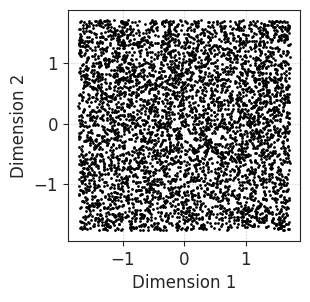

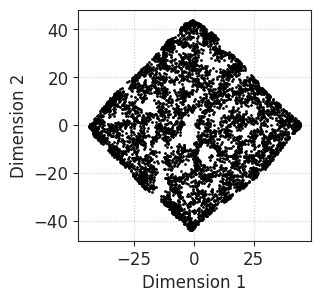

In [15]:
# # Generate data
NUM_SAMPLES = 5000
figNamePrefix = 'uniformSquareIAA'
x = np.random.uniform(-10, 10, NUM_SAMPLES)
y = np.random.uniform(-10, 10, NUM_SAMPLES)
X = np.array([[xi, yi] for xi, yi in zip(x, y)])
# X = np.array([[xi, yi] * 500 for xi, yi in zip(x, y)])

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(X)

# Visualise data 
plotFirst2D(Xscaled, figNamePrefix=figNamePrefix)  # First two dimensions
plotTSNE(Xscaled, figNamePrefix=figNamePrefix, perplexity=100)  # Manifold learning

#### Extracting Archetypes

Here we extract the *4* archetypes from the dataset. For the iterative approach we also compare the results when we split the original dataset into *2* and *8* subsets.

In [9]:
# n = [5000, 50000, 500000]  # p = 4, k = 1, m = 2
# t = [14, 55, 510]

# p = [4, 8, 16, 32, 64]  # n = 50000, k = 1, m = 2
# t = [55, 57, 67, 91, 122]

# n = [500, 1000]  # p = 4, k = 1, m = 1000
# t = [161, 698]

# p = [4, 8, 16]  # n = 500, k = 1, m = 1000
# t = [161, 70, 190]

# plt.plot(p, t)

RSS FISTA = 1880.8073
RSS FISTA = 974.85341
RSS FISTA = 823.91882
RSS AS = 686.06549
RSS AS = 665.15054
RSS AS = 656.03427
RSS AS = 647.55427
RSS AS = 638.83175
RSS AS = 628.65223
RSS AS = 615.13788
RSS AS = 595.65144
RSS AS = 566.56385
RSS AS = 523.45676
RSS AS = 463.04391
RSS AS = 386.84152
RSS AS = 303.18151
RSS AS = 223.92279
RSS AS = 158.39149
RSS AS = 109.66837
RSS AS = 76.221137
RSS AS = 53.534953
RSS AS = 38.191202
RSS AS = 27.796647
RSS AS = 20.684801
RSS AS = 15.71484
RSS AS = 12.153555
RSS AS = 9.5532331
RSS AS = 7.6423764
RSS AS = 6.2131776
RSS AS = 5.1168369
RSS AS = 4.2636321
RSS AS = 3.5933666
RSS AS = 3.0579378
RSS AS = 2.6254252
RSS AS = 2.2719343
RSS AS = 1.9802476
RSS AS = 1.7380078
RSS AS = 1.5354565
RSS AS = 1.3650926
RSS AS = 1.2202526
RSS AS = 1.0958159
RSS AS = 0.9881261
RSS AS = 0.89441293
RSS AS = 0.81245359
RSS AS = 0.74021785
RSS AS = 0.67618351
RSS AS = 0.61952813
RSS AS = 0.56934861
RSS AS = 0.52493547
RSS AS = 0.48754935
RSS AS = 0.45146994
RSS AS = 0.418

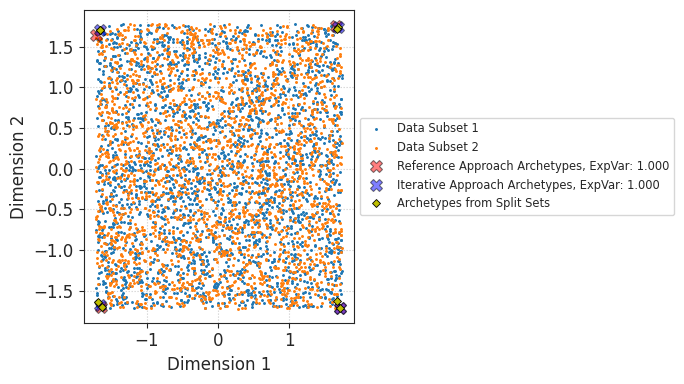

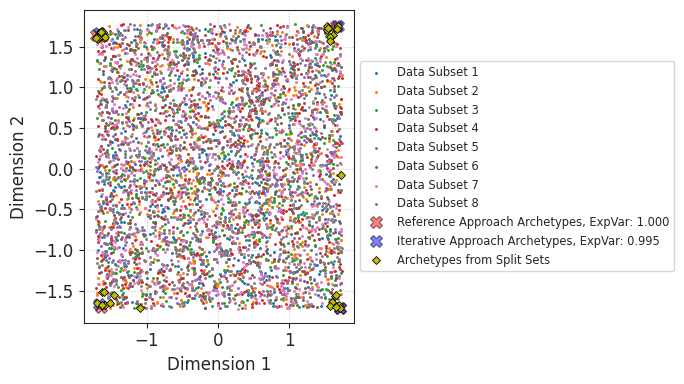

In [10]:
numArchetypes, numSubsets = 4, [2, 8]
AAreference, AAiterative = runAAonData(Xscaled, numArchetypes=numArchetypes, numSubsets=numSubsets, onlyZ=False,
                                       robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE,
                                       datasetType=figNamePrefix, plotSubsets=True,
                                       figSize=FIG_SIZE, dpi=DPI, verbose=VERBOSE)

It could be seen that the final archetypes from both approaches lie very close to each other in the two-dimensional feature space, and the explained variances are both very high.

#### Visualising Most Archetypal Samples

Here we mark out the most archetypal samples in the data.

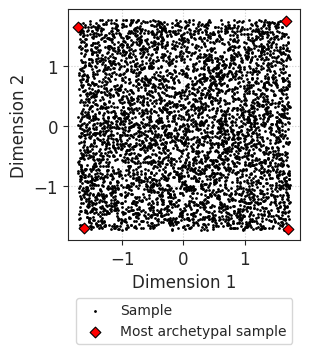

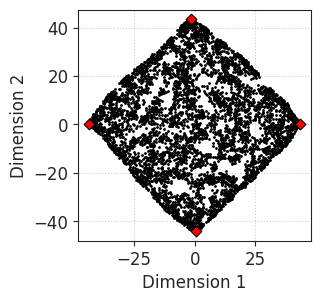

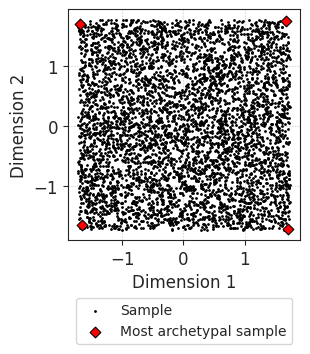

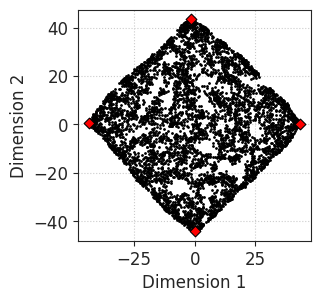

In [11]:
# Reference archetypal analysis
AAreference._extractCloseMatch()
closestSampleIdxsRAA = [sampleIdx for (sampleIdx, archetype) in AAreference.closeMatch.values()]
plotFirst2D(Xscaled, figNamePrefix=f"{figNamePrefix}_rAA", markIdxs=closestSampleIdxsRAA)
plotTSNE(Xscaled, figNamePrefix=f"{figNamePrefix}_rAA", perplexity=100, markIdxs=closestSampleIdxsRAA)

# Iterative archetypal analysis
AAiterative._extractCloseMatch()
closestSampleIdxsIAA = [sampleIdx for (sampleIdx, archetype) in AAiterative.closeMatch.values()]
plotFirst2D(Xscaled, figNamePrefix=f"{figNamePrefix}_iAA", markIdxs=closestSampleIdxsIAA)
plotTSNE(Xscaled, figNamePrefix=f"{figNamePrefix}_iAA", perplexity=100, markIdxs=closestSampleIdxsIAA)

### Blob

#### Load Data

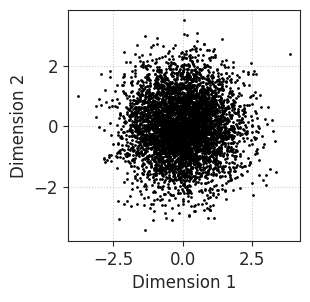

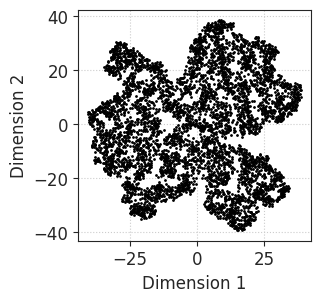

In [16]:
# Generate data
NUM_SAMPLES = 5000
figNamePrefix = 'blobIAA'
X, y_true = make_blobs(n_samples=NUM_SAMPLES, centers=1, cluster_std=30, random_state=0)

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(X)

# Visualise data 
plotFirst2D(Xscaled, figNamePrefix=figNamePrefix)  # First two dimensions
plotTSNE(Xscaled, figNamePrefix=figNamePrefix, perplexity=100)  # Manifold learning

#### Extracting Archetypes

Here we extract the *8* archetypes from the dataset. For the iterative approach we also compare the results when we split the original dataset into *2*, *4*, and *8* subsets.

RSS FISTA = 961.4492
Reference archetypal analysis execution time: 7.220 s
RSS FISTA = 491.93079
RSS FISTA = 314.16137
RSS AS = 235.38947
RSS AS = 134.35871
RSS AS = 50.969545
RSS AS = 6.973985
RSS AS = 2.2164352
RSS AS = 2.1039828
RSS AS = 2.0016218
RSS AS = 1.9077966
RSS AS = 1.8206955
RSS AS = 1.7397886
RSS AS = 1.6647445
RSS AS = 1.595013
RSS AS = 1.5301933
RSS AS = 1.4699417
RSS AS = 1.4139154
RSS AS = 1.3644073
RSS AS = 1.3196855
RSS AS = 1.2776185
RSS AS = 1.238022
RSS AS = 1.2007741
RSS AS = 1.165677
RSS AS = 1.1323592
RSS AS = 1.1006665
RSS AS = 1.0703173
RSS AS = 1.0412
RSS AS = 1.0133676
RSS AS = 0.98688916
RSS AS = 0.96151536
RSS AS = 0.93719411
RSS AS = 0.91388668
RSS AS = 0.89155444
RSS AS = 0.87016023
RSS AS = 0.84966795
RSS AS = 0.83002736
RSS AS = 0.81112972
RSS AS = 0.79293124
RSS AS = 0.77540801
RSS AS = 0.75853704
RSS AS = 0.74229591
RSS AS = 0.72666272
RSS AS = 0.71161631
RSS AS = 0.69713607
RSS AS = 0.68320204
RSS AS = 0.66979481
RSS AS = 0.65689562
RSS AS = 0.644

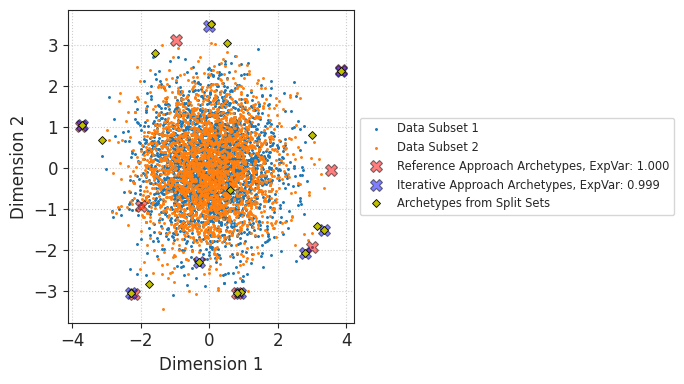

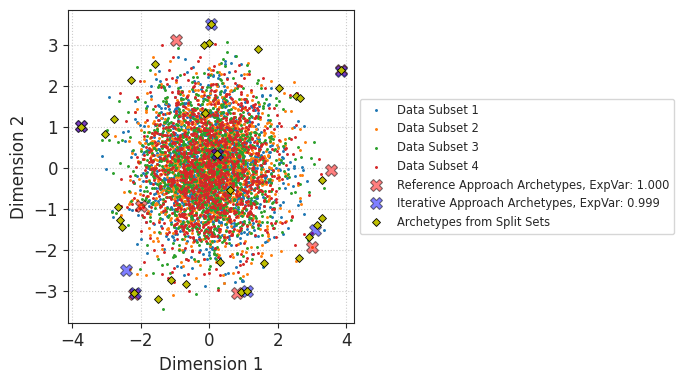

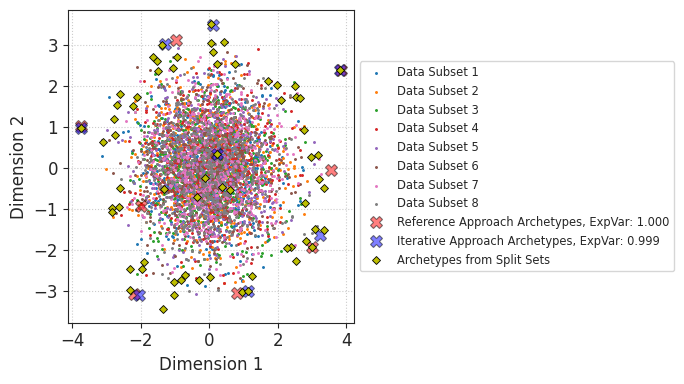

In [13]:
numArchetypes, numSubsets = 8, [2, 4, 8]
AAreference, AAiterative = runAAonData(Xscaled, numArchetypes=numArchetypes, numSubsets=numSubsets, onlyZ=False,
                                       robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE,
                                       datasetType=figNamePrefix, plotSubsets=True,
                                       figSize=FIG_SIZE, dpi=DPI, verbose=VERBOSE)

#### Visualising Most Archetypal Samples

Here we mark out the most archetypal samples in the data.

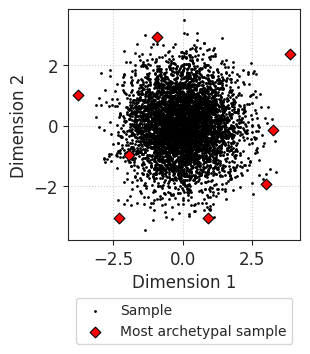

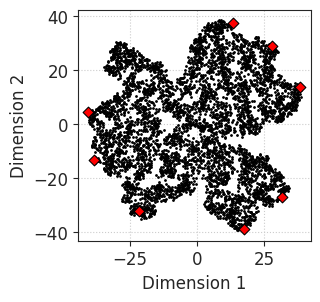

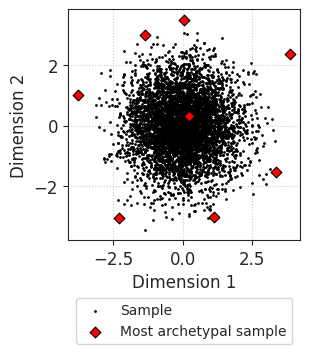

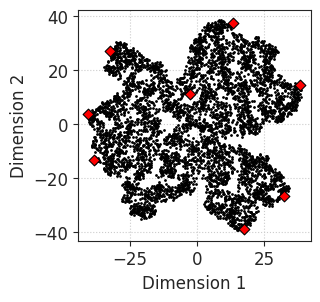

In [14]:
# Reference archetypal analysis
AAreference._extractCloseMatch()
closestSampleIdxsRAA = [sampleIdx for (sampleIdx, archetype) in AAreference.closeMatch.values()]
plotFirst2D(Xscaled, figNamePrefix=f"{figNamePrefix}_rAA", markIdxs=closestSampleIdxsRAA)
plotTSNE(Xscaled, figNamePrefix=f"{figNamePrefix}_rAA", perplexity=100, markIdxs=closestSampleIdxsRAA)

# Iterative archetypal analysis
AAiterative._extractCloseMatch()
closestSampleIdxsIAA = [sampleIdx for (sampleIdx, archetype) in AAiterative.closeMatch.values()]
plotFirst2D(Xscaled, figNamePrefix=f"{figNamePrefix}_iAA", markIdxs=closestSampleIdxsIAA)
plotTSNE(Xscaled, figNamePrefix=f"{figNamePrefix}_iAA", perplexity=100, markIdxs=closestSampleIdxsIAA)

While the locations of the final archetypes from both approaches do not overlap very much with each other in the two-dimensional feature space for this dataset, the explained variances are both very high.

## Functionalities Demonstration

From here onwards we will demonstrate the functionalities provided by *archetypes.py*.

The following functionalities are covered:
- extraction of the archetype attributes, 
- mapping of data to the archetype space,
- visualisation of archetype profiles (contributions of the archetypes in describing any other data sample), 
- identification of the most archetypal data samples, 
- visualisation of the data samples and archetypes on parallel axis.

### Load Data

The skeleton dataset will be used for the following demonstration to allow comparison with previous methods. 

The dataset:
- is a real world dataset used for demonstration in [From Spider-Man to Hero -- Archetypal Analysis in R](https://www.jstatsoft.org/article/view/v030i08). 
- was collected by Heinz G et al. in [Exploring Relationships in Body Dimensions](http://www.amstat.org/publications/jse/v11n2/datasets.heinz.html).
- includes 507 samples, of which 247 are men and 260 are women.
- has 25 features, but only 11 were used in [From Spider-Man to Hero -- Archetypal Analysis in R](https://www.jstatsoft.org/article/view/v030i08).

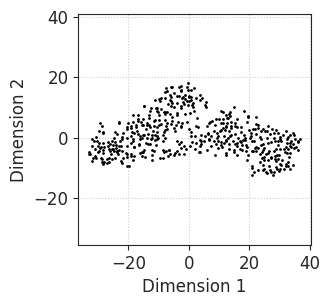

In [17]:
# Load the data
r = requests.get('http://jse.amstat.org/datasets/body.dat.txt')
data = np.array(list(map(lambda x: list(map(float, x.split())), r.text.splitlines())))
figNamePrefix = 'skeletonIAA'

# Order the columns in the similar order that appears in previous studies.
columns = ['AnkleDiam', 'KneeDiam', 'WristDiam', 'Bitro', 'Biil', 'ElbowDiam', 'ChestDiam', 'ChestDp', 'Biac', 'Height', 'Gender']
selectedCols = [8, 7, 6, 2, 1, 5, 4, 3, 0, 23, 24]
df = pd.DataFrame(data[:, selectedCols], columns=columns)

# Map the entries in the gender column into strings
gender = {1.0: 'male', 0.0: 'female'}
df['Gender'] = df.apply(lambda row: gender[row['Gender']], axis = 1)

# Generate the feature set
featNames = ['AnkleDiam', 'KneeDiam', 'WristDiam', 'Bitro', 'Biil', 'ElbowDiam', 'ChestDiam', 'ChestDp', 'Biac', 'Height']
X = df[featNames].values

# Standardise all features
sc = StandardScaler()
Xscaled = sc.fit_transform(X)

# Data visualisation
plotTSNE(Xscaled, figNamePrefix='skeleton', perplexity=30)

### Extracting Attributes from Archetypal Analysis Object

Once the **ArchetypalAnalysis()** object was fitted to the data, we can extract a few outputs from it. 

Below is a list of the attributes that could be extracted. Note that $n$, $m$, and $k$ refers to the number of samples, number of features, and number of archetypes, respectively:
- **.archetypes** returns $Z$ (with a shape of $(m \times k)$), the computed archetypes.
- **.alfa** returns $A$ (with a shape of $(k \times n)$), the coefficient matrix to multiply to $Z$ to approximately reconstruct $X$.
- **.beta** returns $B$ (with a shape of $(n \times k)$), the coefficient matrix to multiply to $X$ to obtain $Z$.
- **.X** returns $X^T$ (with a shape of $(m \times n)$), the transposed original data.
- **.X_approx** returns $X_{\text{approx}}$ (with a shape of $(m \times n)$), the reconstructed data.
- **.explainedVariance_** tells how close is $X_{\text{approx}}$ to $X$. It is computed using *explainedVariance_score()* from the *sklearn* package.
- **.archetype_profile** provides the profile of the archetypes (with a shape of $(m \times n)$). It shows the fraction of importance of each feature for each archetype (which sums to 1.0).
- **.closeMatch** contains the most archetypal data points. It is only computed after **._extractCloseMatch()** is run.
- **.runTime** returns the execution duration (s) of the algorithm for $Z$ to be computed.

The following outputs are only useful when *iterative* is set to *True*:
- **.subsets_sample_idxs** returns the indices of the samples for each data subset.
- **.subsets_Zs** returns the archetypes obtained from each data subset.

In [18]:
numArchetypes, numSubset = 10, 2
AA = ArchetypalAnalysis(nArchetypes=numArchetypes, iterative=True, robust=ROBUST, onlyZ=False, nSubsets=numSubset, shuffle=SHUFFLE, 
                        C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                        randomState=RANDOM_STATE, numThreads=NUM_JOBS)
AA.fit(Xscaled)

RSS FISTA = 847.79012
RSS FISTA = 576.52362
RSS FISTA = 493.41328
RSS AS = 444.80805
RSS AS = 417.09659
RSS AS = 399.59295
RSS AS = 388.19505
RSS AS = 380.0827
RSS AS = 373.73169
RSS AS = 367.87778
RSS AS = 362.29724
RSS AS = 357.08065
RSS AS = 352.68046
RSS AS = 349.05644
RSS AS = 345.97259
RSS AS = 343.09605
RSS AS = 340.59254
RSS AS = 338.39585
RSS AS = 336.587
RSS AS = 335.22448
RSS AS = 334.08407
RSS AS = 333.14975
RSS AS = 332.41919
RSS AS = 331.78672
RSS AS = 331.20814
RSS AS = 330.66141
RSS AS = 330.16103
RSS AS = 329.70468
RSS AS = 329.25053
RSS AS = 328.7618
RSS AS = 328.21816
RSS AS = 327.61126
RSS AS = 326.95712
RSS AS = 326.24638
RSS AS = 325.48111
RSS AS = 324.63536
RSS AS = 323.69763
RSS AS = 322.62913
RSS AS = 321.4178
RSS AS = 320.06882
RSS AS = 318.76883
RSS AS = 317.97476
RSS AS = 317.5451
RSS AS = 317.21207
RSS AS = 316.92921
RSS AS = 316.68311
RSS AS = 316.46712
RSS AS = 316.28003
RSS AS = 316.11938
RSS AS = 315.9819
RSS AS = 315.86361
RSS AS = 315.76128
RSS AS = 3

In [19]:
print(f"Z:\n{AA.archetypes}\n")
print(f"A:\n{AA.alfa}\n")
print(f"B:\n{AA.beta}\n")
print(f"X:\n{AA.X}\n")
print(f"Approximately reconstructed X:\n{AA.Xapprox}\n")
print(f"Explained variance:\n{AA.explainedVariance_:.6f}\n")
print(f"Archetype profiles:\n{AA.archetypeProfile}\n")
print(f"Execution time (s):\n{AA.runTime:.6f}\n")
AA._extractCloseMatch()
print(f"Most archetypal data samples:\n")
for (archNum, (archID, archFeats)) in AA.closeMatch.items():
    print(f"  Archetype {archNum}:    ID = {archID},    feats = {archFeats}")
print(f"Subset sample IDs:\n{AA.subsetsSampleIdxs}\n")
print(f"Subset archetypes:\n{AA.subsetsZs}\n")

Z:
[[-1.81373673e+00  2.33253870e+00  4.67862050e-01  2.57260152e+00
   8.34835752e-03  1.16177084e+00 -1.31939048e+00  6.46751499e-01
  -1.38031113e-03 -1.12939091e-01]
 [-1.92653646e+00  1.62173079e+00 -3.53184630e-01  1.31156621e+00
   3.31802786e+00  1.76458340e+00 -1.69040211e+00  3.44977355e-02
   1.48311626e-01  1.22060096e+00]
 [-2.17349899e+00  3.14042360e-01  1.54350716e+00  1.53322241e+00
   2.32443575e+00  1.09656015e+00 -7.64578006e-01  1.28167778e-01
  -6.53182218e-01 -1.35502819e-01]
 [-1.82423332e+00  2.72699245e+00  1.28987939e+00  5.39244983e-01
   1.57060104e+00  3.28300188e-01 -1.99230678e+00 -1.82133047e+00
  -4.68377813e-01  2.57256432e+00]
 [-9.63567313e-01  1.93895992e+00  1.57530439e+00  1.22704228e+00
   1.23942139e+00  1.18696034e-01 -3.99967367e+00 -9.99834402e-02
  -7.12125277e-01  2.02513217e+00]
 [-2.20738044e+00  1.90041953e+00  1.65632621e+00  1.24318352e+00
   1.35735918e+00  1.07087109e+00 -1.14674028e+00  9.89328073e-02
  -3.29151486e-01  4.32559121e

### Selecting the Appropriate Number of Archetypes

Here we use the elbow criterion to figure out the most appropriate choice of number of archetypes, $k$.

RSS FISTA = 784.08413
RSS FISTA = 662.3076
RSS FISTA = 632.97032
RSS AS = 618.04299
RSS AS = 610.08745
RSS AS = 604.54776
RSS AS = 600.6536
RSS AS = 597.84616
RSS AS = 595.69858
RSS AS = 593.9636
RSS AS = 592.56501
RSS AS = 591.42661
RSS AS = 590.47497
RSS AS = 589.71136
RSS AS = 589.10242
RSS AS = 588.61743
RSS AS = 588.23252
RSS AS = 587.92822
RSS AS = 587.68857
RSS AS = 587.50066
RSS AS = 587.35666
RSS AS = 587.24787
RSS AS = 587.16848
RSS AS = 587.11239
RSS AS = 587.07059
RSS AS = 587.03838
RSS AS = 587.01386
RSS AS = 586.99502
RSS AS = 586.98044
RSS AS = 586.96917
RSS AS = 586.96046
RSS AS = 586.95373
RSS AS = 586.94854
RSS AS = 586.94462
RSS AS = 586.9421
RSS AS = 586.94054
RSS AS = 586.93958
RSS AS = 586.93898
RSS AS = 586.93861
RSS AS = 586.93838
RSS AS = 586.93823
RSS AS = 586.93814
RSS AS = 586.93809
RSS AS = 586.93805
RSS AS = 586.93803
RSS AS = 586.93802
RSS AS = 586.93801
RSS AS = 586.93801
RSS AS = 586.938
RSS AS = 586.938
RSS AS = 586.938
RSS AS = 586.938
RSS AS = 586.93

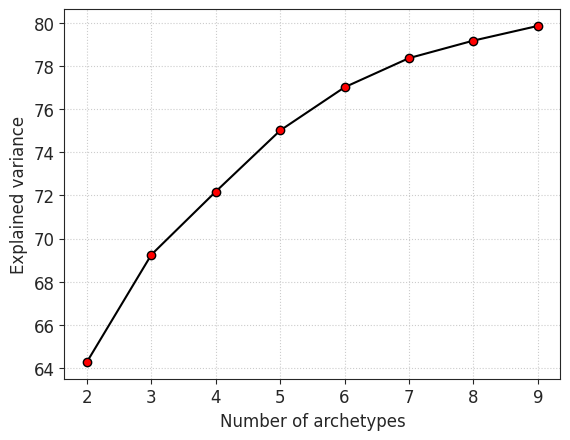

In [20]:
numSubset = 3
allNumArchetypes, expVars = range(2, 10), []
for numArchetypes in allNumArchetypes:
    AAiterative = ArchetypalAnalysis(nArchetypes=numArchetypes, iterative=True, robust=ROBUST, onlyZ=False, nSubsets=numSubset, shuffle=SHUFFLE, 
                                     C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                                     randomState=RANDOM_STATE, numThreads=NUM_JOBS)
    AAiterative.fit(Xscaled)
    expVars.append(AAiterative.explainedVariance_)
plt.plot(allNumArchetypes, [expVar*100 for expVar in expVars], 
         color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Explained variance')
plt.grid(linestyle='dotted')
plt.savefig(f"{FIGS_DIR_PATH}/{figNamePrefix}_elbow.png", bbox_inches='tight')

As the elbow occurs when **3** archetypes are used, we refit the data with this value. This also allows comparisons with the previous results from [Benyamin Motevalli](https://researchdata.edu.au/archetypal-analysis-package/1424520) and [Manuel J. A. Eugster](https://www.jstatsoft.org/article/view/v030i08).

In [21]:
numArchetypes = 3
AA = ArchetypalAnalysis(nArchetypes=numArchetypes, iterative=True, robust=ROBUST, onlyZ=False, nSubsets=numSubset, shuffle=SHUFFLE, 
                        C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                        randomState=RANDOM_STATE, numThreads=NUM_JOBS)
AA.fit(Xscaled)

RSS FISTA = 728.57203
RSS FISTA = 594.85969
RSS FISTA = 566.41034
RSS AS = 548.42162
RSS AS = 536.37636
RSS AS = 526.50907
RSS AS = 516.84528
RSS AS = 506.66489
RSS AS = 495.91639
RSS AS = 485.80008
RSS AS = 478.18448
RSS AS = 473.50554
RSS AS = 471.22894
RSS AS = 470.10794
RSS AS = 469.47188
RSS AS = 469.05891
RSS AS = 468.76425
RSS AS = 468.53122
RSS AS = 468.33087
RSS AS = 468.148
RSS AS = 467.96504
RSS AS = 467.7691
RSS AS = 467.55181
RSS AS = 467.30529
RSS AS = 467.01952
RSS AS = 466.68839
RSS AS = 466.31591
RSS AS = 465.89138
RSS AS = 465.40845
RSS AS = 464.89223
RSS AS = 464.35038
RSS AS = 463.77535
RSS AS = 463.17092
RSS AS = 462.53198
RSS AS = 461.85994
RSS AS = 461.14774
RSS AS = 460.38391
RSS AS = 459.56461
RSS AS = 458.71683
RSS AS = 457.86972
RSS AS = 457.07925
RSS AS = 456.33666
RSS AS = 455.64194
RSS AS = 454.98295
RSS AS = 454.35578
RSS AS = 453.74259
RSS AS = 453.14822
RSS AS = 452.59743
RSS AS = 452.11085
RSS AS = 451.68761
RSS AS = 451.32959
RSS AS = 451.02185
RSS AS

### Mapping Data to Archetype Space

We can map the data samples to the convex hull formed by the archetypes using simplex plots.

Number of labels <8, nullifying `labelAll`, showing all labels...


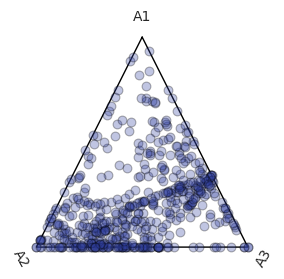

In [32]:
archIDs = list(range(AA.nArchetypes))
AA.plotSimplex(AA.alfa, archIDs, figSize=(3, 3), alpha=0.3, markerSize=40, figNamePrefix=figNamePrefix)

Number of labels <8, nullifying `labelAll`, showing all labels...


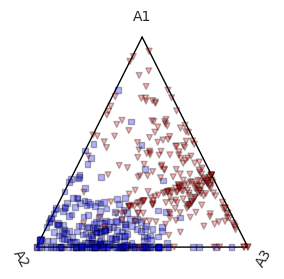

In [37]:
# Users have the flexibility to assign attributes (marker color, marker shape, marker size) to the data samples to enrich the plot.
dfArgs = df[['Gender']].copy()
dfArgs.loc[:, 'color'] = 'red'
dfArgs.loc[dfArgs['Gender']=='female', 'color'] = 'blue'

dfArgs.loc[:, 'marker'] = 'v'
dfArgs.loc[dfArgs['Gender']=='female', 'marker'] = 's'

dfArgs.loc[:, 'size'] = df[['Height']] / 10

plotArgs = {'color': dfArgs['color'], 's': dfArgs['size'], 'marker': dfArgs['marker']}

AA.plotSimplex(AA.alfa, archIDs, plotArgs, figSize=(3, 3), alpha=0.3, figNamePrefix=figNamePrefix)

Additional utility functions are included to allow more flexibities to create simplex plots and color the data points in different fashions. This requires three steps:
1. Create the simplex plot frame with **createSimplexAx** utility function.
2. Map the **.alfa** values to the simplex frame using the **mapAlfaToSimplex** utility function.
3. Use standard matplotlib scatter plot to visualise data points.

Number of labels <8, nullifying `labelAll`, showing all labels...


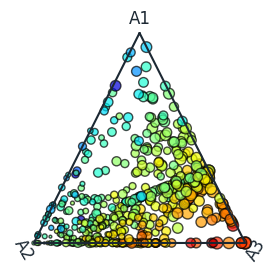

In [24]:
# STEP 1: Create the simplex plot. Users can control the color of gridlines and borders (edges) of the simplex plots. 
createSimplexAx(AA, gridOn=True, gridcolor='#EAECEE', bordercolor='#1C2833', fontcolor='#1C2833', figSize=(3, 3))
# STEP 2: Map the alfa values to simplex plot.
mappedAlfa = mapAlfaToSimplex(AA.alfa, AA)
# STEP 3: Use scatter plots to add the mapped alfa to simplex frame.
# The data points are colored by 'Biil' attribute, while sizes are correlated to normalised 'ChestDiam'.
df['ChestDiamNorm'] = (df['ChestDiam'] - df['ChestDiam'].min()) / (df['ChestDiam'].max() - df['ChestDiam'].min())
plt.scatter(mappedAlfa[:,0], mappedAlfa[:,1], 
            c=df['Biil'], cmap='jet', edgecolor='k', 
            s=df['ChestDiamNorm'] * 80, alpha=0.7);
plt.savefig(f"{FIGS_DIR_PATH}/{figNamePrefix}_SizeColour_simplex.png", bbox_inches='tight')

Any other point (e.g. prototypes of clusters) can also be mapped to the simplex plot to compare their relative locations (with other points provided or the overall dataset).

Number of labels <8, nullifying `labelAll`, showing all labels...


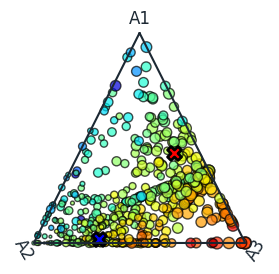

In [25]:
# STEP 1: Get the alpha values for males and females.
XavgMale = Xscaled[df['Gender'] == 'male'].mean(axis=0).reshape(1, -1)
XavgFemale = Xscaled[df['Gender'] == 'female'].mean(axis=0).reshape(1, -1)
_, alfaMale = AA.transform(XavgMale)
_, alfaFemale = AA.transform(XavgFemale)

# STEP 2: Create the simplex plot.
createSimplexAx(AA, gridOn=True, gridcolor='#EAECEE', bordercolor='#1C2833', fontcolor='#1C2833', figSize=(3, 3))

# STEP 3: Map the alphas values to the plot.
mappedAlfa = mapAlfaToSimplex(AA.alfa, AA)
mappedAlfaMale = mapAlfaToSimplex(alfaMale, AA)
mappedAlfaFemale = mapAlfaToSimplex(alfaFemale, AA)

# STEP 4: Plot the data samples.
df['ChestDiamNorm'] = (df['ChestDiam']-df['ChestDiam'].min()) / (df['ChestDiam'].max()-df['ChestDiam'].min())
plt.scatter(mappedAlfa[:, 0], mappedAlfa[:, 1], c=df['Biil'], cmap='jet', edgecolor='k', s=df['ChestDiamNorm'] * 80, alpha=0.7);
plt.scatter(mappedAlfaMale[:, 0], mappedAlfaMale[:, 1], marker='X', s=100, color='r', edgecolor='k', linewidth=2);
plt.scatter(mappedAlfaFemale[:, 0], mappedAlfaFemale[:, 1], marker='X', s=100, color='b', edgecolor='k', linewidth=2);
plt.savefig(f"{FIGS_DIR_PATH}/{figNamePrefix}_markPrototype_simplex.png", bbox_inches='tight')

### Visualising Archetype Profiles

The profile of the archetypes can be plot as bar plots or radar plots.

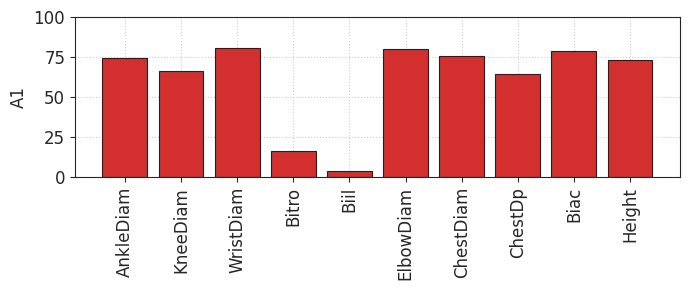

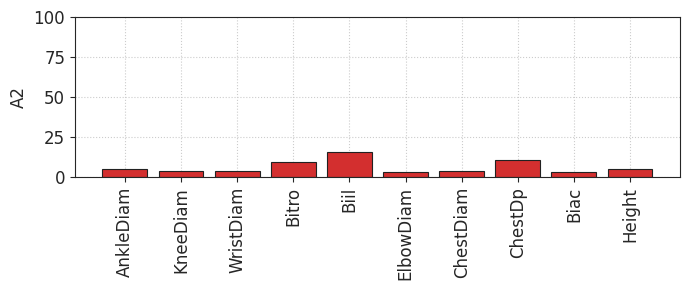

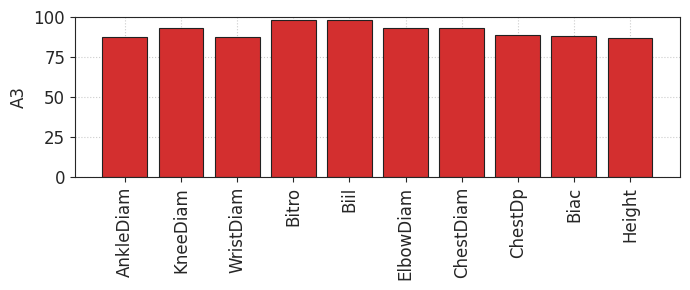

In [26]:
featIDs = range(len(featNames))
AA.plotProfile(featNames, featIDs, archIDs, figSize=(7, 3), figNamePrefix=figNamePrefix)

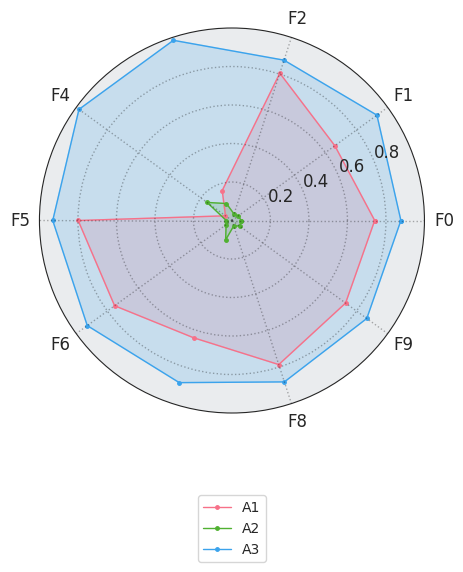

In [27]:
AA.plotRadarProfile(featNames, featIDs, archIDs, sepArchs=False, showLabel=True, figSize=(5, 5), figNamePrefix=figNamePrefix)

### Identifying Most Archetypal Data Samples

The most archetypal data samples could be identified by running **._extractCloseMatch()** on the **ArchetypalAnalysis()** object.

Regarding the **.closeMatch** object:
- The keys are the archetypes.
- The first item in the tuple gives the index of the most archetypal data sample.
- The second item is the corresponding $\alpha$ array of that data point.

The data samples can be mapped to a simplex plot or displayed on a radar plot.

In [28]:
AA._extractCloseMatch()
AA.closeMatch

{1: (109, array([0.76479943, 0.09884302, 0.13635755])),
 2: (249, array([0.        , 0.92027823, 0.07972177])),
 3: (144, array([0.10426882, 0.01347575, 0.88225543]))}

Number of labels <8, nullifying `labelAll`, showing all labels...


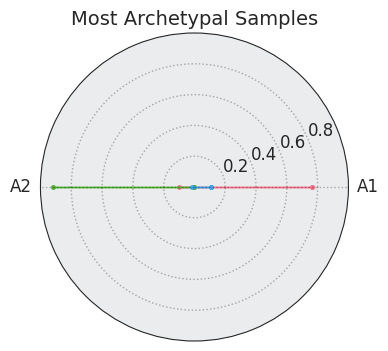

In [46]:
# Radar plot of the most archetypal data samples in the archetype space
archIDs = [0, 1, 2]
AA.plotCloseMatch(archIDs, title='Most Archetypal Samples', figSize=(4, 4), figNamePrefix=figNamePrefix)

Number of labels <8, nullifying `labelAll`, showing all labels...


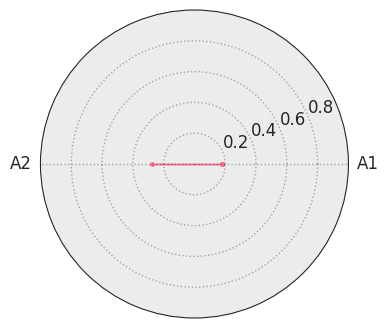

In [45]:
# Any data sample in the archetype space can also be plotted
idxs = [10]
ax = plotRadarDatapoints(AA, Xscaled, sampIDs=idxs, figSize=(4, 4), figNamePrefix=figNamePrefix)

### Visualing Most Archetypal Samples on 2D Embedding Space from Manifold Learning

The most archetypal data samples can also be marked out on the 2D embedding space obtained from manifold learning (*t*-SNE in our case).

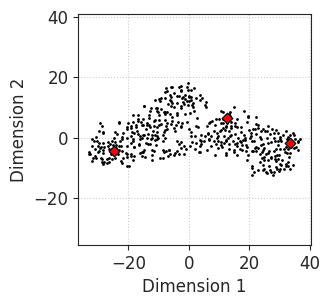

In [47]:
closestSampleIdxs = [sampleIdx for (sampleIdx, archetype) in AA.closeMatch.values()]
plotTSNE(Xscaled, figNamePrefix=figNamePrefix, markIdxs=closestSampleIdxs)

### Visualing Samples and Archetypes on Parallel Axis

The data samples and archetypes could also be plotted on a parallel axis.

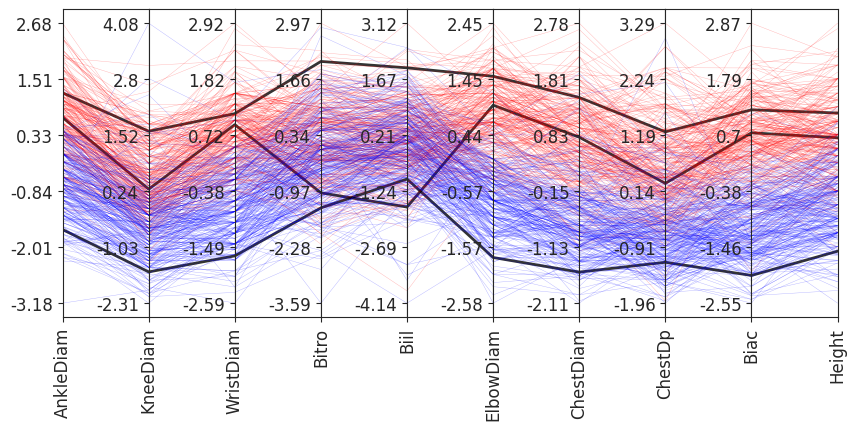

In [63]:
AA.parallelPlot(featNames, dfArgs[['color']].copy(), 
                featIDs=range(len(featNames)), archIDs=range(numArchetypes), sampIDs=range(df.shape[0]),
                linewidth='0.3', archColor='k', figSize=(10, 4), figNamePrefix=figNamePrefix)